In [41]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path):
    try:
        image = Image.open(image_path)

        image = np.array(image)
        # if len(image.shape) == 3 and image.shape[2] == 4:
            # image = cv2.cvtColor(image, cv2.COlOR_RGB2BGR)
            #swap RGB to BGR while preserviing alpha channel.
            # image = image[:,:,[2,1,0,3]]
        return image
    except Exception as e:
        print("error loading image " + image_path)
        raise e

def load_and_pad_image(image_path, target_width, target_height):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # If the image does not have an alpha channel, add one
    # if image.shape[2] == 3:
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

    # Calculate padding
    height, width = image.shape[:2]
    pad_top = (target_height - height) // 2
    pad_bottom = target_height - height - pad_top
    pad_left = (target_width - width) // 2
    pad_right = target_width - width - pad_left

    # Pad the image with transparent pixels
    padded_image = cv2.copyMakeBorder(
        image, pad_top, pad_bottom, pad_left, pad_right, 
        cv2.BORDER_CONSTANT, value=[0, 0, 0, 0]
    )

    return padded_image
    
def overlay_image(source, overlay, x_start,x_end,y_start,y_end):

    #linear blend 

    # [blend_images]
    alpha = 0.9
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(source, beta, overlay, alpha, 0.0)
    return dst

def display_image(image):
    plt.figure(figsize=(10,8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def calc_dim_resize(image, target_height,target_width):
    resized_image = cv2.resize(image, (target_height,target_width))
    return resized_image

source shape: 
(499, 504, 4)
overlay shape: 
(499, 504, 4)


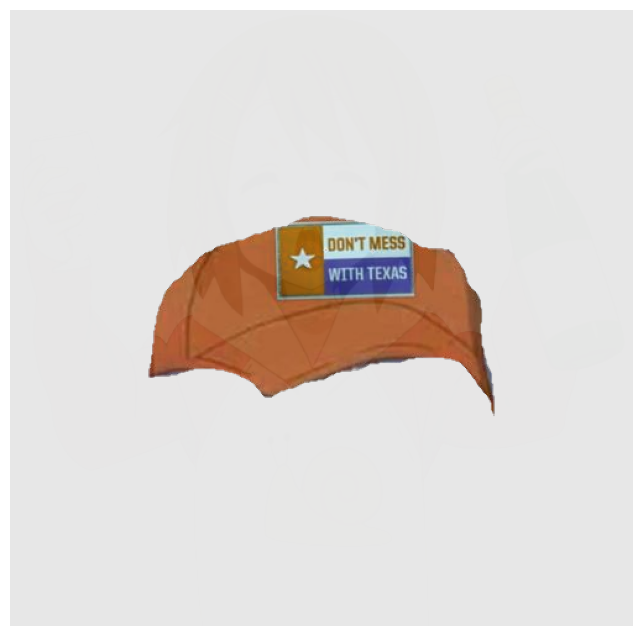

In [42]:
image_path = 'images/source_pic.png'
overlay_path = 'images/texas-cap-transparent.png'

source = load_image(image_path)
overlay = load_and_pad_image(overlay_path, source.shape[1], source.shape[0])

print("source shape: " )
print(source.shape)
print("overlay shape: " )
print(overlay.shape)

y_start , y_end = 2, 62
x_start , x_end = 158, 330

result = overlay_image(source, overlay,y_start , y_end,x_start , x_end )

display_image(result)